In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import librosa
import librosa.display
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import warnings
warnings.simplefilter("ignore")


In [2]:
# Download coughvid data in CDF format
# Run once 
!git clone "https://github.com/virufy/virufy-cdf-coughvid.git"
%cd virufy-cdf-coughvid

Cloning into 'virufy-cdf-coughvid'...
remote: Enumerating objects: 22051, done.
remote: Total 22051 (delta 0), reused 0 (delta 0), pack-reused 22051
Receiving objects: 100% (22051/22051), 1006.41 MiB | 6.59 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Updating files: 100% (22045/22045), done.
/Users/abdirrahman/Desktop/virufy-cdf-coughvid-main/virufy-cdf-coughvid


In [3]:
coughvid = pd.read_csv("/Users/abdirrahman/desktop/virufy-cdf-coughvid-main/virufy-cdf-coughvid.csv")
msk = (coughvid.loc[:,'cough_detected'] > 0.7)
coughvid = coughvid.loc[msk,:]

In [4]:
# Filtering cough_detected to > .7 is advisable
# The .7 threshold can be tuned as part of model development, we recommend testing different thresholds after a model has been completed
coughvid.head()

,Unnamed: 0,source,patient_id,cough_detected,cough_path,age,biological_sex,reported_gender,submission_date,pcr_test_date,pcr_result_date,respiratory_condition,fever_or_muscle_pain,pcr_test_result,pcr_test_result_inferred,covid_symptoms
0,0,coughvid,ae029647-ddc3-47f5-904e-813358c9dda3,0.8929,virufy-cdf-coughvid/ae029647-ddc3-47f5-904e-81...,NaN,NaN,NaN,2020-10-20T11:05:04.501905+00:00,NaN,NaN,NaN,NaN,untested,untested,NaN
4,4,coughvid,68d5215b-afdb-4b7a-81d3-fbd5677de7b4,1.0000,virufy-cdf-coughvid/68d5215b-afdb-4b7a-81d3-fb...,46.0,male,male,2020-11-26T16:21:47.764016+00:00,NaN,NaN,False,False,untested,negative,False
5,5,coughvid,3449851d-799e-404e-b143-58e852332948,0.9825,virufy-cdf-coughvid/3449851d-799e-404e-b143-58...,47.0,male,male,2020-04-14T19:39:05.755132+00:00,NaN,NaN,False,False,untested,negative,False
6,6,coughvid,0c35e382-31cd-42cb-bc87-8a84b9c52a41,1.0000,virufy-cdf-coughvid/0c35e382-31cd-42cb-bc87-8a...,27.0,female,female,2020-04-13T09:11:44.729740+00:00,NaN,NaN,False,False,positive,positive,NaN
9,9,coughvid,3ee8bfb5-a1d4-46c6-9b1c-3052af9bdedf,0.9943,virufy-cdf-coughvid/3ee8bfb5-a1d4-46c6-9b1c-30...,NaN,NaN,NaN,2020-04-12T20:09:17.098213+00:00,NaN,NaN,NaN,NaN,untested,untested,NaN


In [5]:
# Disclaimer: we have inferred some of these pcr_test_result labels based on other columns
# Target = pcr_test_result_inferred
# Positive, negative, untested

coughvid['pcr_test_result_inferred'].head(30)

0     untested
4     negative
5     negative
6     positive
9     untested
12    negative
13    untested
14    negative
15    negative
16    untested
17    untested
18    untested
20    negative
21    negative
22    negative
24    negative
25    negative
26    negative
28    negative
31    untested
33    untested
34    untested
35    negative
39    negative
40    untested
41    untested
42    untested
44    untested
45    negative
46    negative
Name: pcr_test_result_inferred, dtype: object

In [6]:
# Filter out untested results
msk = (coughvid.loc[:,'pcr_test_result_inferred']=='untested')
coughvid = coughvid.loc[~msk,:]
coughvid

,Unnamed: 0,source,patient_id,cough_detected,cough_path,age,biological_sex,reported_gender,submission_date,pcr_test_date,pcr_result_date,respiratory_condition,fever_or_muscle_pain,pcr_test_result,pcr_test_result_inferred,covid_symptoms
4,4,coughvid,68d5215b-afdb-4b7a-81d3-fbd5677de7b4,1.0000,virufy-cdf-coughvid/68d5215b-afdb-4b7a-81d3-fb...,46.0,male,male,2020-11-26T16:21:47.764016+00:00,NaN,NaN,False,False,untested,negative,False
5,5,coughvid,3449851d-799e-404e-b143-58e852332948,0.9825,virufy-cdf-coughvid/3449851d-799e-404e-b143-58...,47.0,male,male,2020-04-14T19:39:05.755132+00:00,NaN,NaN,False,False,untested,negative,False
6,6,coughvid,0c35e382-31cd-42cb-bc87-8a84b9c52a41,1.0000,virufy-cdf-coughvid/0c35e382-31cd-42cb-bc87-8a...,27.0,female,female,2020-04-13T09:11:44.729740+00:00,NaN,NaN,False,False,positive,positive,NaN
12,12,coughvid,cdd18865-400a-448e-902b-c8b53644a1c8,0.9881,virufy-cdf-coughvid/cdd18865-400a-448e-902b-c8...,24.0,male,male,2020-11-28T20:14:22.235183+00:00,NaN,NaN,False,False,untested,negative,False
14,14,coughvid,0e35f667-974e-4ffc-b596-1b9a94793d1b,0.9658,virufy-cdf-coughvid/0e35f667-974e-4ffc-b596-1b...,18.0,male,male,2020-04-14T10:52:04.775637+00:00,NaN,NaN,False,False,untested,negative,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22013,22013,coughvid,2986534b-37ef-408b-b6ec-b107225d7e8b,0.9865,virufy-cdf-coughvid/2986534b-37ef-408b-b6ec-b1...,58.0,male,male,2020-11-24T13:24:35.904905+00:00,NaN,NaN,False,False,untested,negative,False
22021,22021,coughvid,8e53179c-cff5-4dff-bec8-a78e38f79b67,0.9891,virufy-cdf-coughvid/8e53179c-cff5-4dff-bec8-a7...,16.0,male,male,2020-11-09T13:04:10.570155+00:00,NaN,NaN,False,False,untested,negative,False
22026,22026,coughvid,f9a73dc7-95c6-4e96-9f48-e9d3d9db818b,0.9918,virufy-cdf-coughvid/f9a73dc7-95c6-4e96-9f48-e9...,33.0,male,male,2020-07-10T06:30:49.755996+00:00,NaN,NaN,False,False,untested,negative,False
22029,22029,coughvid,ccc3b8b2-8c07-4aaa-adad-f8304402ecc1,0.9890,virufy-cdf-coughvid/ccc3b8b2-8c07-4aaa-adad-f8...,24.0,male,male,2020-04-09T22:52:43.174014+00:00,NaN,NaN,False,False,untested,negative,False


In [7]:
# Test/Train split
stratify_labels = coughvid["pcr_test_result_inferred"].map(lambda x: x if x is "positive" else "untested")
cdf_train, cdf_test = train_test_split(coughvid, test_size=0.2, random_state = 0, stratify = stratify_labels)

In [8]:
cdf_train.shape, cdf_test.shape


((6212, 16), (1554, 16))

In [9]:
cdf_train.shape[1]

16

In [10]:
# Functions to process audio files into images and json features
def trim_silence(x, *args):
    try:pad,db_max,frame_length,hop_length = args[0],args[1],args[2],args[3]
    except: 
        print('Please enter the following arguments: pad,db_max,frame_length,hop_length')
        return

    _, ints = librosa.effects.trim(x, top_db=db_max, frame_length=256, hop_length=64)
    start = int(max(ints[0]-pad, 0))
    end   = int(min(ints[1]+pad, len(x)))
    return x[start:end]

def process_cough_file(path,trim,*args):
    try: sr,removeaudio,chunk,db_max = args[0],args[1],args[2],args[3]
    except: 
        sr,removeaudio,chunk,db_max= 48000,False,3,50
    try:
        x,sr = librosa.load(path, sr=sr)       
    except: 
        return -1
    
    if len(x)/sr < 0.3 or len(x)/sr > 30:
        return None,None  
    hop_length = np.floor(0.010*sr).astype(int) #10ms
    win_length = np.floor(0.020*sr).astype(int) #20ms  

    if removeaudio:
        os.remove(path)
    
    x = trim(x, 0.25*sr, db_max,win_length,hop_length) 
    x = x[:np.floor(chunk*sr).astype(int)]
    
    #pads to chunk size if smaller
    x_pad = np.zeros(int(sr*chunk))
    x_pad[:min(len(x_pad), len(x))] = x[:min(len(x_pad), len(x))]

    return [x_pad,sr,hop_length,win_length]

def get_melspec(sdir,audio,sr,name):
    #Mel Spectogram
    plt.ioff()
    fig      = plt.figure()
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)
    fig.canvas.draw()
    img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig=fig)
    #img = img[80:250,80:300]

    savepath = os.path.join(sdir,name+'.png') # Currently saving melspectrogram images to the folders specified in extract features
    cv2.imwrite(savepath,img)
    return savepath

def get_rawMFCCs(audio,sr,*args):
    try: hop_length,win_length,n_mfcc,n_mels,n_ftt = args[0],args[1],args[2],args[3],args[4]
    except:
        hop_length = np.floor(0.010*sr).astype(int) #10ms
        win_length = np.floor(0.020*sr).astype(int) #20ms  
        n_mfcc,n_mels,n_ftt=13,13,2048

    rawMFCCs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=n_mfcc,n_mels=n_mels, n_fft=n_ftt, hop_length=hop_length)
    rawMFCCs    = np.mean(rawMFCCs.T,axis=0).tolist()

    return rawMFCCs

def getlabel(key, dataframe, chosen):
      return dataframe.loc[dataframe[chosen['id']]==key][chosen['pcr']].tolist()[0]

def extract(df, chosen, savedir):
    if not os.path.isdir(savedir):
        os.mkdir(savedir)
        
    keys, dirs = df[chosen['id']].tolist(),df[chosen['path']].tolist()  
    audio_objs = [process_cough_file(path,trim_silence) for path in dirs]
    false_indices = [i for i in range(len(audio_objs)) if isinstance(audio_objs[i],int) or isinstance(audio_objs[i],tuple)]

    audio_objs = [audio_objs[i] for i in range(len(audio_objs)) if i not in false_indices]
    audio_objs = np.array(audio_objs)
    audio,sr,hop_length,win_length = audio_objs[:,0],audio_objs[:,1],audio_objs[:,2],audio_objs[:,3]
    
    dirs = [dirs[i] for i in range(len(dirs)) if i not in false_indices]
    keys = [keys[i] for i in range(len(keys)) if i not in false_indices]
    data = {key:{'DIR':get_melspec(savedir,a_i,sr_i,key),
             'rawMFCC':get_rawMFCCs(a_i,sr_i),
             'label':getlabel(key, df, chosen)} for key,a_i,sr_i in list(zip(keys,audio,sr))}
    return data

def filter_DF(df):
    names = list(df.columns)
    chosen= {}
    for name in names:
        if 'inferred' in name.lower():chosen['pcr'] = name # Choosing the target (pcr_test_result_inferred)
        elif 'path' in name.lower():chosen['path'] = name
        elif 'patient' in name.lower() or 'id' == name.lower() :chosen['id'] = name
    return df[[chosen['id'],chosen['pcr'],chosen['path']]].dropna().reset_index(), chosen 

def extract_features(train_df, test_df):
    train_dataframe, train_chosen = filter_DF(train_df)
    test_dataframe, test_chosen = filter_DF(test_df)
    
    train_features = extract(train_dataframe, train_chosen,'train_melspecs/')
    test_features = extract(test_dataframe, test_chosen,'test_melspecs/')
    
    return train_features, test_features

In [12]:
# Json format dictionaries
train_features, test_features = extract_features(cdf_train, cdf_test)

In [13]:
# Optional: Save json features
with open('train_features.json', 'w') as f:
    json.dump(train_features, f, indent=4)
with open('test_features.json', 'w') as f:
    json.dump(test_features, f, indent=4)

In [21]:
from swishnet import *
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split 
from datetime import datetime

In [47]:
train_dataset = pd.read_json('train_features.json', 'index')
train_dataset.head()

,DIR,rawMFCC,label
feb9cd98-1e54-42b8-950c-f1e8dbd1e814,train_melspecs/feb9cd98-1e54-42b8-950c-f1e8dbd...,"[-145.77175120424056, 35.96589135448887, -9.72...",negative
511b8b47-b97a-45d8-9b23-db64c972182d,train_melspecs/511b8b47-b97a-45d8-9b23-db64c97...,"[-143.4610447441653, 23.97383899519964, -11.29...",negative
cffd2f05-7935-4bed-89ad-27e3745deadd,train_melspecs/cffd2f05-7935-4bed-89ad-27e3745...,"[-141.3741994613426, 33.39232061055834, -8.586...",negative
3a5cf958-22cc-4dee-937d-894a73e9173d,train_melspecs/3a5cf958-22cc-4dee-937d-894a73e...,"[-105.42878179395109, 43.571653952920336, -18....",negative
144cd672-7f14-4fe9-952b-450ca6f16536,train_melspecs/144cd672-7f14-4fe9-952b-450ca6f...,"[-133.24265959742044, 42.99237067200866, -1.54...",negative


In [48]:
validation_dataset = pd.read_json('test_features.json', 'index')
validation_dataset.head()

,DIR,rawMFCC,label
8643a84c-2312-4049-a298-46f6172c0cdc,test_melspecs/8643a84c-2312-4049-a298-46f6172c...,"[-167.46298667398148, 26.091265786654784, -11....",negative
e136f725-f618-40e9-82e9-d4712a5479dd,test_melspecs/e136f725-f618-40e9-82e9-d4712a54...,"[-154.61565645128007, 37.06437783314282, -4.82...",positive
794029a7-53b9-47ef-aaef-c10814c0d126,test_melspecs/794029a7-53b9-47ef-aaef-c10814c0...,"[-187.6614769551593, 24.255618977167916, 1.590...",negative
9dc98a4b-7219-41e6-ac5a-02aa8ea8bbd4,test_melspecs/9dc98a4b-7219-41e6-ac5a-02aa8ea8...,"[-274.81884005855034, 24.85263366244586, 0.034...",negative
c76dcf90-f920-4ea2-ba15-2542f6399b6e,test_melspecs/c76dcf90-f920-4ea2-ba15-2542f639...,"[-136.78685069453806, 33.12754065729615, -18.8...",negative


In [49]:
#Further Preprocessing
X_train = np.array(train_dataset.rawMFCC.tolist())
y_train = np.array(train_dataset.label.tolist())
X_validation = np.array(validation_dataset.rawMFCC.tolist())
y_validation = np.array(validation_dataset.label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy_train = to_categorical(le.fit_transform(y_train))
yy_validation = to_categorical(le.fit_transform(y_validation))

In [64]:
X_train.shape


(6212, 13)

In [75]:
#Data reshaping for CNN Architecture
num_rows = 13 
num_columns = 1 
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns) 
X_validation = X_validation.reshape(X_validation.shape[0], num_rows, num_columns)
num_labels = yy_train.shape[1]

In [76]:
model = SwishNet(input_shape=(13,1), classes=2,width_multiply=2) #SwishNet Wide
# Compile the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
# Display model architecture summary
model.summary()

2021-12-03 17:14:35.526581: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 13, 1)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 13, 16)       64          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 13, 16)       64          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 13, 16)       112         input_1[0][0]                    
______________________________________________________________________________________________

In [77]:
num_epochs = 15
num_batch_size = 32
start = datetime.now()
history = model.fit(X_train, yy_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_validation, yy_validation), verbose=1)
duration = datetime.now() - start 
print("Training completed in time: ", duration)

2021-12-03 17:15:07.619855: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
195/195 [==============================] - 5s 13ms/step - loss: 0.2909 - accuracy: 0.9250 - val_loss: 0.2746 - val_accuracy: 0.9215
Epoch 2/15
195/195 [==============================] - 2s 10ms/step - loss: 0.2671 - accuracy: 0.9250 - val_loss: 0.2759 - val_accuracy: 0.9215
Epoch 3/15
195/195 [==============================] - 2s 11ms/step - loss: 0.2658 - accuracy: 0.9250 - val_loss: 0.2751 - val_accuracy: 0.9215
Epoch 4/15
195/195 [==============================] - 2s 11ms/step - loss: 0.2638 - accuracy: 0.9250 - val_loss: 0.2712 - val_accuracy: 0.9215
Epoch 5/15
195/195 [==============================] - 2s 11ms/step - loss: 0.2631 - accuracy: 0.9250 - val_loss: 0.2684 - val_accuracy: 0.9215
Epoch 6/15
195/195 [==============================] - 2s 10ms/step - loss: 0.2618 - accuracy: 0.9250 - val_loss: 0.2683 - val_accuracy: 0.9215
Epoch 7/15
195/195 [==============================] - 2s 11ms/step - loss: 0.2605 - accuracy: 0.9250 - val_loss: 0.2686 - val_accuracy: 0.9215

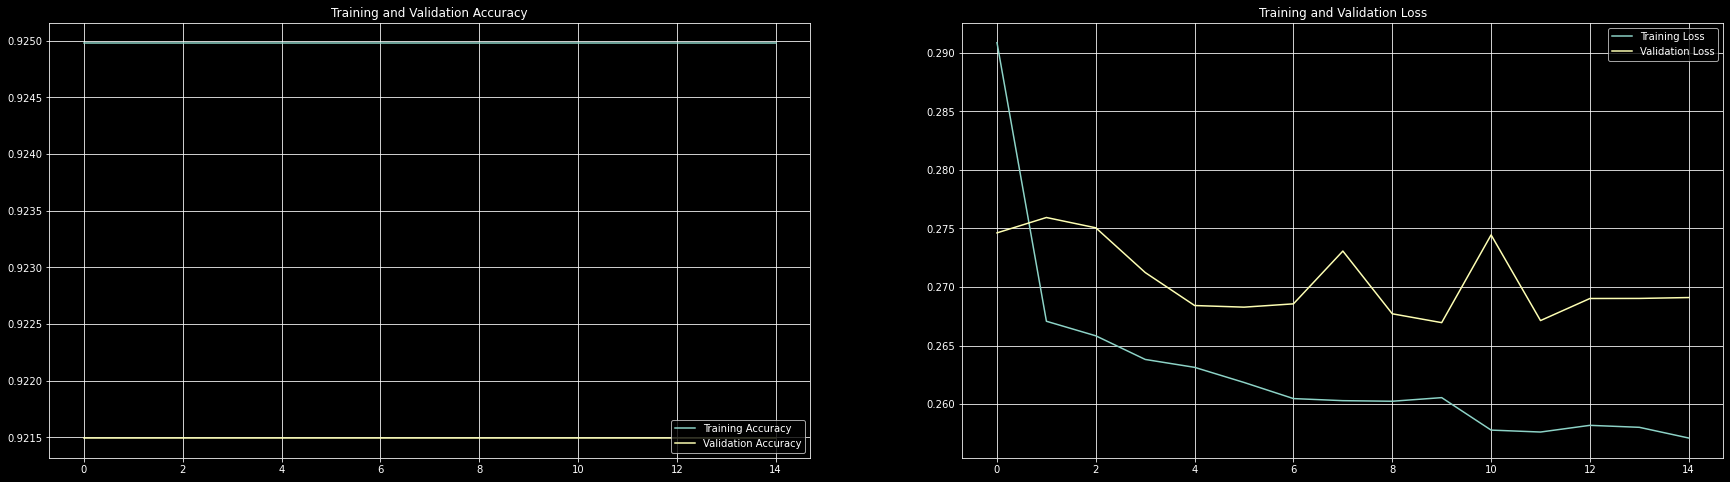

In [78]:
plt.style.use('dark_background')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(30, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [79]:
# Evaluating the model on the training and validation set
score = model.evaluate(X_train, yy_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))

score = model.evaluate(X_validation, yy_validation, verbose=0)
print("Validation Accuracy: {0:.2%}".format(score[1]))

Training Accuracy: 92.50%
Validation Accuracy: 92.15%
